In [1]:
import os
import rootpath
import sys
sys.path.append(rootpath.detect())

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

from testsuite.results import ResultsContainer
from testsuite.utilities import str_format, single_target_dominated_hypervolume
from testsuite.analysis_tools import strip_problem_names, get_factors
import wfg
from collections import defaultdict

In [2]:
# establish location to save tables
output_table_dir = os.path.join(rootpath.detect(), 'experiments/directed/results/tables/')
assert os.path.isdir(output_table_dir)

In [3]:
# establish location from which to load data
RESULTS_DIR = os.path.join(rootpath.detect(), 'experiments/directed/data/')
TEST_FUNCTIONS = sorted(os.listdir(RESULTS_DIR))
FUNCTION_DIRS = [os.path.join(RESULTS_DIR, tc, 'log_data/') for tc in TEST_FUNCTIONS]

In [4]:
TEST_FUNCTIONS

['wfg1_2obj_3dim',
 'wfg1_3obj_4dim',
 'wfg1_4obj_5dim',
 'wfg2_2obj_6dim',
 'wfg2_3obj_6dim',
 'wfg2_4obj_10dim',
 'wfg3_2obj_6dim',
 'wfg3_3obj_10dim',
 'wfg3_4obj_10dim',
 'wfg4_2obj_6dim',
 'wfg4_3obj_8dim',
 'wfg4_4obj_8dim',
 'wfg5_2obj_6dim',
 'wfg5_3obj_8dim',
 'wfg5_4obj_10dim',
 'wfg6_2obj_6dim',
 'wfg6_3obj_8dim',
 'wfg6_4obj_10dim']

In [5]:
# generate dictionary of problem targets 
targets_path = os.path.join(rootpath.detect(), 'experiments/directed/template/targets/targets')
with open(targets_path, "r") as infile:
    targets_old = json.load(infile)
targets_old = {k.lower(): np.asarray(v) for k, v in targets_old.items()}

TARGETS_DICT = {}
for function in TEST_FUNCTIONS:
    try:
        # corrrects ordering mistake in function target orders
        TARGETS_DICT[function] = np.vstack((targets_old[function][:3][np.argsort(targets_old[function][:3, 0])],targets_old[function][3:][np.argsort(targets_old[function][3:, 0])]))
    except KeyError:
        n_obj = int(function.split("_")[1].strip("obj"))
        TARGETS_DICT[function] = np.vstack((targets_old[f"ellipsoid_{n_obj}obj"][:3][np.argsort(targets_old[f"ellipsoid_{n_obj}obj"][:3, 0])],targets_old[f"ellipsoid_{n_obj}obj"][3:][np.argsort(targets_old[f"ellipsoid_{n_obj}obj"][3:, 0])]))
        

del(targets_old)

In [6]:
TARGETS_DICT

{'wfg1_2obj_3dim': array([[0.354, 3.139],
        [0.393, 3.487],
        [0.433, 3.836],
        [1.508, 0.979],
        [1.675, 1.088],
        [1.843, 1.197]]),
 'wfg1_3obj_4dim': array([[0.332, 1.352, 1.308],
        [0.369, 1.502, 1.453],
        [0.406, 1.652, 1.599],
        [0.805, 0.31 , 1.894],
        [0.895, 0.345, 2.104],
        [0.984, 0.379, 2.314]]),
 'wfg1_4obj_5dim': array([[0.00506805, 0.01450383, 2.0741083 , 2.67170142],
        [0.00563116, 0.01611537, 2.30456478, 2.96855713],
        [0.00619428, 0.01772691, 2.53502125, 3.26541285],
        [0.2840733 , 0.33494929, 0.59489375, 0.77715356],
        [0.315637  , 0.37216588, 0.66099306, 0.86350396],
        [0.3472007 , 0.40938246, 0.72709236, 0.94985435]]),
 'wfg2_2obj_6dim': array([[0.302, 2.46 ],
        [0.336, 2.734],
        [0.369, 3.007],
        [1.181, 1.179],
        [1.312, 1.309],
        [1.443, 1.44 ]]),
 'wfg2_3obj_6dim': array([[1.042, 0.293, 0.731],
        [1.158, 0.325, 0.812],
        [1.274, 0.

In [7]:
# split targets dict into 3
D_unattainable = {k: [np.asarray(v[i]) for i in [0, 3]] for k, v in TARGETS_DICT.items()}
D_pareto = {k: [np.asarray(v[i]) for i in [1, 4]] for k, v in TARGETS_DICT.items()}
D_attainable = {k: [np.asarray(v[i]) for i in [2, 5]] for k, v in TARGETS_DICT.items()}

In [8]:
D_pareto

{'wfg1_2obj_3dim': [array([0.393, 3.487]), array([1.675, 1.088])],
 'wfg1_3obj_4dim': [array([0.369, 1.502, 1.453]),
  array([0.895, 0.345, 2.104])],
 'wfg1_4obj_5dim': [array([0.00563116, 0.01611537, 2.30456478, 2.96855713]),
  array([0.315637  , 0.37216588, 0.66099306, 0.86350396])],
 'wfg2_2obj_6dim': [array([0.336, 2.734]), array([1.312, 1.309])],
 'wfg2_3obj_6dim': [array([1.158, 0.325, 0.812]),
  array([0.094, 1.644, 2.058])],
 'wfg2_4obj_10dim': [array([0.05926112, 2.59963043, 0.0247067 , 1.3672962 ]),
  array([2.67992847e-01, 5.93682017e-09, 1.49883826e-02, 6.53265411e+00])],
 'wfg3_2obj_6dim': [array([0.4, 3.2]), array([1.401, 1.199])],
 'wfg3_3obj_10dim': [array([0.2  , 0.4  , 4.799]),
  array([0.7  , 1.401, 1.798])],
 'wfg3_4obj_10dim': [array([0.14002801, 0.28005601, 0.84016803, 5.75955191]),
  array([0.44008802, 0.88017604, 2.64052811, 0.95859172])],
 'wfg4_2obj_6dim': [array([1.904, 1.225]), array([0.985, 3.48 ])],
 'wfg4_3obj_8dim': [array([0.51, 3.67, 1.83]), array([1.7

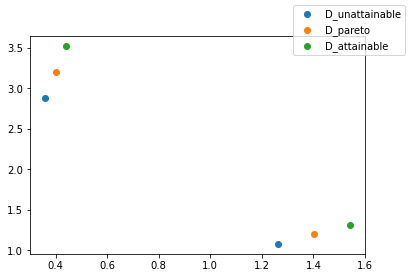

In [9]:
prob = 'wfg3_2obj_6dim'
Ds = [D_unattainable, D_pareto, D_attainable]
names = ['D_unattainable', 'D_pareto', 'D_attainable']

fig = plt.figure()
ax = fig.gca()
for i, D in enumerate(Ds):
    ax.scatter(*np.asarray(D[prob]).T, c=f"C{i}", label=names[i])
fig.legend()

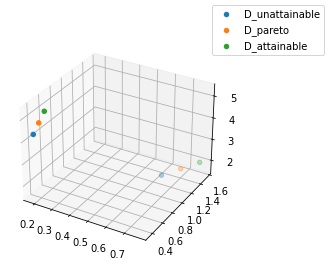

In [10]:
prob = 'wfg3_3obj_10dim'
Ds = [D_unattainable, D_pareto, D_attainable]
names = ['D_unattainable', 'D_pareto', 'D_attainable']

fig = plt.figure()
ax = fig.gca(projection="3d")
for i, D in enumerate(Ds):
    ax.scatter(*np.asarray(D[prob]).T, c=f"C{i}", label=names[i])
fig.legend()

In [11]:
# write function to load data based on dict.
def target_to_Result(results_dir, prob_name, t):
    """
    takes in a directory for results, the name of the problem and the target value,
    returns the ResultsContainer for all repeats from this experiment
    """
    ## check supplied data
    assert os.path.isdir(results_dir)
    assert prob_name in TEST_FUNCTIONS 
    assert prob_name in TARGETS_DICT.keys() 
    
    target_string = str(np.round(t, 2)).replace(".", "p").replace(" ", "_").replace("[","").replace("]", "")
    problem_files = [i for i in os.listdir(results_dir)
                     if i[:len(prob_name)] == prob_name]
#     target_files = [i for i in processed_files]
    
    for pf in os.listdir(results_dir):
        if (target_string in pf) and (prob_name in pf):
            return ResultsContainer(os.path.join(results_dir, pf))
        

name = 'wfg2_2obj_6dim'
processed_results_dir = "../processed_results" 
results = target_to_Result(results_dir=processed_results_dir, prob_name=name, t=TARGETS_DICT[name][0])
results

In [12]:
results.hpv_hist_x

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150])

<AxesSubplot:xlabel='Function evaluations', ylabel='Dominated Hypervolume'>

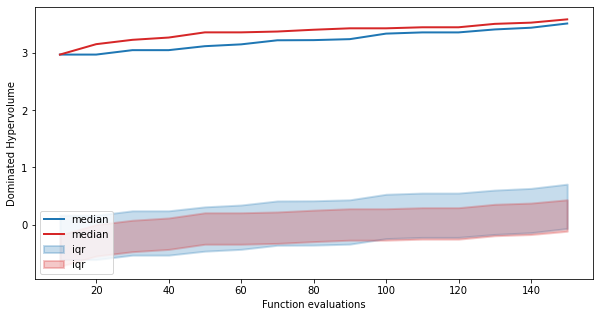

In [13]:
fig = results.plot_hpv()
results.plot_hpv(axis=fig.gca(), reference=True, c="C3")

In [12]:
results0 = target_to_Result(results_dir=processed_results_dir, prob_name=name, t=TARGETS_DICT[name][1])
results0.get_intervals(measure= 'hpv', intervals=[10], reference=False)

(array([2.47680032]),
 array([[0.86686295],
        [0.96055716]]))

<AxesSubplot:xlabel='Function evaluations', ylabel='Dominated Hypervolume'>

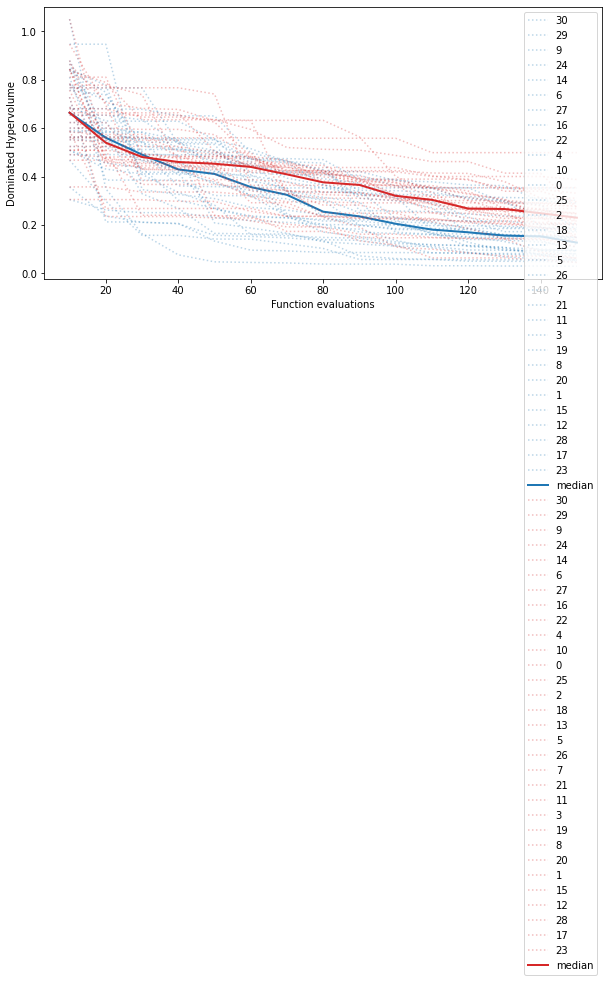

In [17]:
fig = results.plot_igd()
results.plot_igd(axis=fig.gca(), c="C3", reference=True)

<AxesSubplot:xlabel='Function evaluations', ylabel='Dominated Hypervolume'>

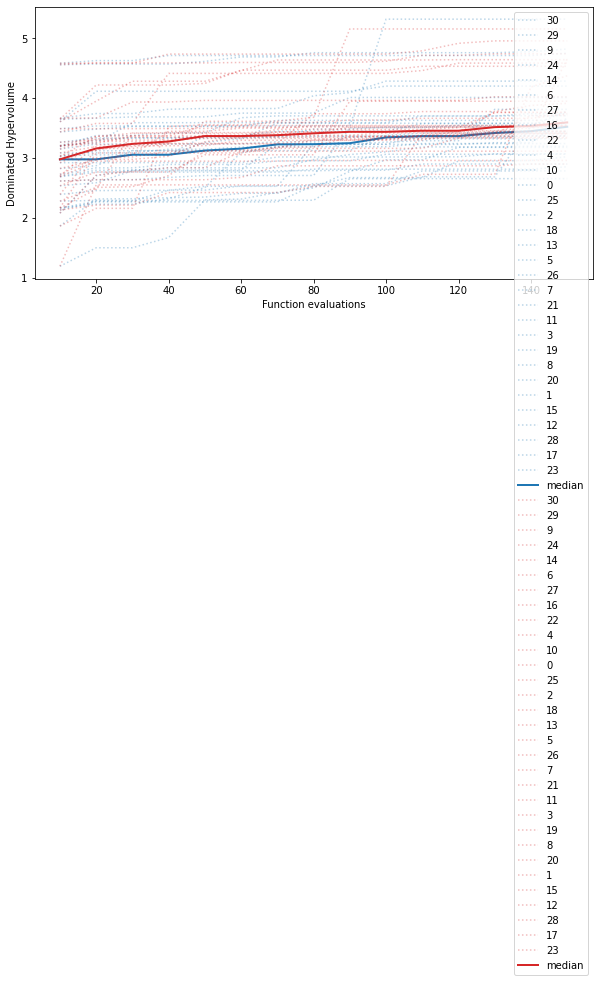

In [19]:
fig = results.plot_hpv()
results.plot_hpv(axis=fig.gca(), c="C3", reference=True)

In [146]:
results.get_intervals(measure= 'igd', intervals=stages, reference=False)

(array([0.41071053, 0.20515251, 0.12746284]),
 array([[0.05439181, 0.03987286, 0.03115975],
        [0.06724628, 0.04274896, 0.03386209]]))

In [147]:
results.get_intervals(measure= 'hpv', intervals=stages, reference=False)

(array([3.12393345, 3.34403339, 3.52126959]),
 array([[2.26878953, 2.53698439, 2.66457858],
        [2.27233162, 2.54250073, 2.68397243]]))

In [14]:
n_target_locations = 2
n_opt_stages = 3
stages = [50, 100, 150]
D_pareto_table = {}
for name, targets in TARGETS_DICT.items():
    row = np.zeros(n_target_locations*n_opt_stages*2)
    for ti, target in enumerate(targets):
        result = target_to_Result(results_dir=processed_results_dir,
                                  prob_name=name,
                                  t = target)
        med, iqr = result.get_intervals(measure= 'igd', intervals=stages, reference=False)
        row[0:6:2] = med
        row[1:6:2] = abs(iqr[0]-iqr[1])
        
        med, iqr = result.get_intervals(measure= 'hpv', intervals=stages, reference=False)
        row[6::2] = med
        row[7::2] = abs(iqr[0]-iqr[1])
        
        D_pareto_table[(name, f"target {ti+1}")] = row


In [17]:
header = [np.array(['a1','a2','a3','a4','a5','a6']), 
          np.array(['b1','b2','b3','b4'])] 

ind = pd.MultiIndex.from_tuples(zip(["IGD"]*6+["HPV"]*6, [50, 50, 100, 100, 150, 150]*2, ['median', 'iqr']*6))
pd.DataFrame(D_pareto_table, index=ind)

wfg1_2obj_3dim                                          \
                     target 1  target 2  target 3  target 4  target 5   
IGD 50  median       1.020583  1.020583  1.020583  1.020583  1.020583   
        iqr          0.001035  0.001035  0.001035  0.001035  0.001035   
    100 median       0.980733  0.980733  0.980733  0.980733  0.980733   
        iqr          0.000784  0.000784  0.000784  0.000784  0.000784   
    150 median       0.980733  0.980733  0.980733  0.980733  0.980733   
        iqr          0.000784  0.000784  0.000784  0.000784  0.000784   
HPV 50  median       0.391732  0.391732  0.391732  0.391732  0.391732   
        iqr          0.006073  0.006073  0.006073  0.006073  0.006073   
    100 median       0.446906  0.446906  0.446906  0.446906  0.446906   
        iqr          0.005797  0.005797  0.005797  0.005797  0.005797   
    150 median       0.496881  0.496881  0.496881  0.496881  0.496881   
        iqr          0.013170  0.013170  0.013170  0.013170  0.013170   

                         wfg1_3obj_4dim                                ...  \
                target 6       target 1  target 2  target 3  target 4  ...   
IGD 50  median  1.020583       1.444002  1.444002  1.444002  1.444002  ...   
        iqr     0.001035       0.003679  0.003679  0.003679  0.003679  ...   
    100 median  0.980733       1.444002  1.444002  1.444002  1.444002  ...   
        iqr     0.000784       0.003679  0.003679  0.003679  0.003679  ...   
    150 median  0.980733       1.441275  1.441275  1.441275  1.441275  ...   
        iqr     0.000784       0.003679  0.003679  0.003679  0.003679  ...   
HPV 50  median  0.391732       0.698824  0.698824  0.698824  0.698824  ...   
        iqr     0.006073       0.000000  0.000000  0.000000  0.000000  ...   
    100 median  0.446906       0.829390  0.829390  0.829390  0.829390  ...   
        iqr     0.005797       0.000000  0.000000  0.000000  0.000000  ...   
    150 median  0.496881       0.891381  0.891381  0.891381  0.891381  ...   
        iqr     0.013170       0.000000  0.000000  0.000000  0.000000  ...   

               wfg6_3obj_8dim                               wfg6_4obj_10dim  \
                     target 3  target 4  target 5  target 6        target 1   
IGD 50  median       0.405637  0.405637  0.405637  0.405637    8.293142e-01   
        iqr          0.002323  0.002323  0.002323  0.002323    2.241920e-02   
    100 median       0.180262  0.180262  0.180262  0.180262    2.214976e-01   
        iqr          0.000374  0.000374  0.000374  0.000374    1.932067e-03   
    150 median       0.121762  0.121762  0.121762  0.121762    1.566167e-01   
        iqr          0.000035  0.000035  0.000035  0.000035    6.309551e-04   
HPV 50  median       0.000000  0.000000  0.000000  0.000000    0.000000e+00   
        iqr          0.000000  0.000000  0.000000  0.000000    0.000000e+00   
    100 median       0.005200  0.005200  0.005200  0.005200    4.042086e-04   
        iqr          0.000000  0.000000  0.000000  0.000000    0.000000e+00   
    150 median       0.016911  0.016911  0.016911  0.016911    4.589116e-03   
        iqr          0.000069  0.000069  0.000069  0.000069    1.507546e-07   

                                                                        \
                    target 2      target 3      target 4      target 5   
IGD 50  median  8.293142e-01  8.293142e-01  8.293142e-01  8.293142e-01   
        iqr     2.241920e-02  2.241920e-02  2.241920e-02  2.241920e-02   
    100 median  2.214976e-01  2.214976e-01  2.214976e-01  2.214976e-01   
        iqr     1.932067e-03  1.932067e-03  1.932067e-03  1.932067e-03   
    150 median  1.566167e-01  1.566167e-01  1.566167e-01  1.566167e-01   
        iqr     6.309551e-04  6.309551e-04  6.309551e-04  6.309551e-04   
HPV 50  median  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
        iqr     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    100 median  4.042086e-04  4.042086e-04  4.042086

In [22]:
D_pareto

{'wfg1_2obj_3dim': [array([0.393, 3.487]), array([1.675, 1.088])],
 'wfg1_3obj_4dim': [array([0.369, 1.502, 1.453]),
  array([0.895, 0.345, 2.104])],
 'wfg1_4obj_5dim': [array([0.00563116, 0.01611537, 2.30456478, 2.96855713]),
  array([0.315637  , 0.37216588, 0.66099306, 0.86350396])],
 'wfg2_2obj_6dim': [array([0.336, 2.734]), array([1.312, 1.309])],
 'wfg2_3obj_6dim': [array([1.158, 0.325, 0.812]),
  array([0.094, 1.644, 2.058])],
 'wfg2_4obj_10dim': [array([0.05926112, 2.59963043, 0.0247067 , 1.3672962 ]),
  array([2.67992847e-01, 5.93682017e-09, 1.49883826e-02, 6.53265411e+00])],
 'wfg3_2obj_6dim': [array([0.4, 3.2]), array([1.401, 1.199])],
 'wfg3_3obj_10dim': [array([0.2  , 0.4  , 4.799]),
  array([0.7  , 1.401, 1.798])],
 'wfg3_4obj_10dim': [array([0.14002801, 0.28005601, 0.84016803, 5.75955191]),
  array([0.44008802, 0.88017604, 2.64052811, 0.95859172])],
 'wfg4_2obj_6dim': [array([1.904, 1.225]), array([0.985, 3.48 ])],
 'wfg4_3obj_8dim': [array([0.51, 3.67, 1.83]), array([1.7